In [6]:
! pip install pandas numpy scikit-learn scipy opencv-python seaborn scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -------- ------------------------------- 2.9/12.9 MB 18.6 MB/s eta 0:00:01
   ----------------------- ---------------- 7.6/12.9 MB 19.6 MB/s eta 0:00:01
   -------------------------------------- - 12.6/12.9 MB 21.3 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 20.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 15.5 MB/s eta 0:00:00


Prøver meg på task 1

### Preprocessing

see ass 1 for ting

redigering av bilde
- resizing
- cropping
- reducing noise
- 

Histogram based features
- color histogram
- grayscale histogram
- local binary patterns
- HOG
    - Crop image 
    - resize to fit 64x128
    - calculate gradient image(x,y, magnitude(sobel filter?))
    - calculate histogram of gradients(magnitude and direction) in a 8x8 cell
    - 16x16 block normalization
    - Calculate the Histogram of Oriented Gradients feature vector
- canny edge (can use multiple threshold last time we only used 1)
- sobel edge 
- PCA?

### Basic model

- kjører på med en SVM siden NN blir brukt senere og ender opp med å bli mer avansert enn de andre basic modellene

              precision    recall  f1-score   support

   buildings       0.83      0.82      0.83       450
      forest       0.93      0.91      0.92       472
     glacier       0.65      0.70      0.67       455
    mountain       0.67      0.66      0.67       515
         sea       0.80      0.78      0.79       485
      street       0.82      0.82      0.82       430

    accuracy                           0.78      2807
   macro avg       0.78      0.78      0.78      2807
weighted avg       0.78      0.78      0.78      2807



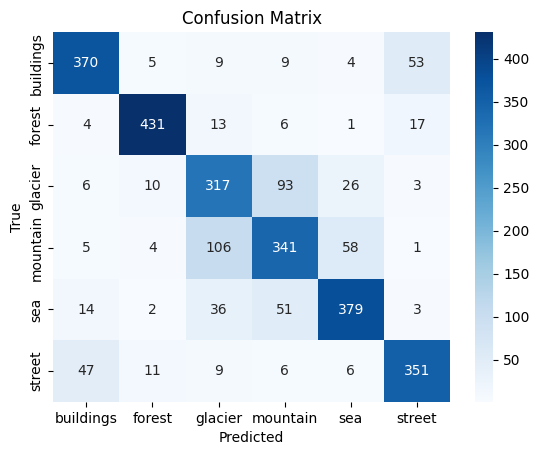

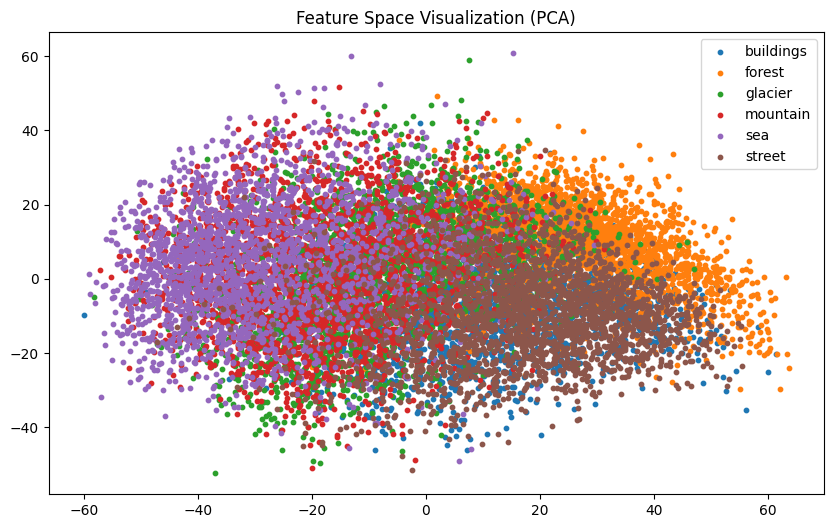

In [9]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to preprocess each image
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Extract HOG features
    features, _ = hog(
        gray_image,
        pixels_per_cell=(16, 16),
        cells_per_block=(4, 4),
        visualize=True,
        block_norm='L2-Hys'
    )
    return features

# Load dataset
def load_dataset(data_dir):
    features = []
    labels = []
    # Iterate through each folder (class)
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):  # Ensure it's a folder
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                try:
                    # Preprocess the image
                    feature_vector = preprocess_image(image_path)
                    features.append(feature_vector)
                    labels.append(label)  # Use folder name as label
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
    # Ensure feature vectors are of fixed shape
    max_length = max(len(f) for f in features)
    features = np.array([np.pad(f, (0, max_length - len(f))) for f in features])
    labels = np.array(labels)
    return features, labels


# Load data from your dataset path
data_dir = "../../data/intel-image-classification/seg_train/seg_train"
features, labels = load_dataset(data_dir)



# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train an SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(labels))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Visualize features in 2D space using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label, s=10)
plt.title("Feature Space Visualization (PCA)")
plt.legend()
plt.show()


Classification Report:
              precision    recall  f1-score   support

   buildings       0.84      0.82      0.83       437
      forest       0.90      0.93      0.91       474
     glacier       0.66      0.68      0.67       553
    mountain       0.64      0.68      0.66       525
         sea       0.78      0.72      0.75       510
      street       0.86      0.84      0.85       501

    accuracy                           0.77      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.77      0.77      0.77      3000



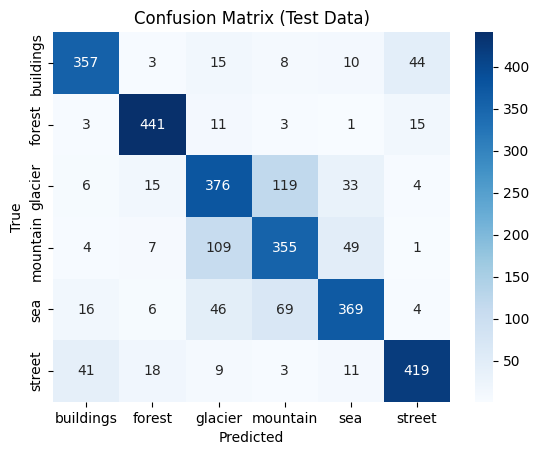

In [10]:
# Path to test dataset
test_data_dir = "../../data/intel-image-classification/seg_test/seg_test"

# Load the test data
test_features, test_labels = load_dataset(test_data_dir)

# Normalize the test features using the same scaler from training
test_features = scaler.transform(test_features)  # scaler should be the one used during training

# Predict on test data
test_predictions = svm_model.predict(test_features)

# Evaluate the model
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions, labels=np.unique(test_labels))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()